In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from datetime import timedelta
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Donor Retention Analysis and Prediction Using XGBoost

## Overview
This notebook presents a step-by-step analysis of donor data to predict **retention behavior** using machine learning. Specifically, it uses the XGBoost classifier and SHAP values for interpretability. The dataset includes historical transaction records from Sam’s Fans and helps answer the question: _Which donors are likely to return?_

---

## 1. Data Loading and Preparation
We begin by loading the dataset and parsing the `"Date"` column as datetime objects to enable time-based feature engineering.

We then sort the dataset by `"Account Number"` and `"Date"` to preserve chronological order for each donor.

---

## 2. Feature Engineering
We generate donor-level features by grouping all transactions per donor and aggregating:

- **first_donation**: Date of first donation  
- **last_donation**: Date of most recent donation  
- **frequency**: Number of donations made  
- **total_amount**: Total amount donated  

We also compute additional features:

- **recency_days**: Days since the last donation  
- **donation_span_days**: Number of days between the first and last donation  
- **avg_donation**: Average donation per transaction  

These features summarize each donor’s history and behavior.

---

## 3. Creating the Target Variable: Retention
A donor is considered **retained** if they made another donation within **90 days** of any previous donation. We calculate this by checking time gaps between consecutive donations.

If a donor has at least one pair of donations within 90 days, they are labeled as `retained = 1`; otherwise, `retained = 0`.

---

## 4. Model Training with XGBoost
We select the following features to build our model:

- `frequency`
- `total_amount`
- `recency_days`
- `donation_span_days`
- `avg_donation`

We split the data into training and test sets using an 80/20 ratio. Then, we train an `XGBClassifier` to predict donor retention.

---

## 5. Model Evaluation
After training the model, we evaluate its performance using:

- **Classification Report**: Precision, Recall, F1-Score  
- **Confusion Matrix**: Number of true positives, false positives, etc.  
- **Sensitivity and Specificity**: Measures of performance for each class  

These metrics provide a detailed view of how well the model distinguishes between retained and non-retained donors.

---

## 6. Interpreting the Model with SHAP
To make our model interpretable, we use SHAP (SHapley Additive exPlanations):

### Beeswarm Plot
The SHAP beeswarm plot shows how each feature influences the model's predictions across all donors. It highlights the most impactful variables and the direction of their effect.

### Waterfall Plot
For a specific donor, the SHAP waterfall plot breaks down how individual feature values contributed to the final prediction. This helps us understand why the model predicted retention (or not) for that donor.

In [151]:
# Step 1: Load the dataset and parse the "Date" column as datetime objects
df = pd.read_excel("Sam's_Fans_All_Transactions_All_Time.xlsx", parse_dates=["Date"])

# Step 2: Sort the data by Account Number and Date to maintain chronological order per donor
df.sort_values(by=["Account Number", "Date"], inplace=True)

# Step 3: Create donor-level features using groupby aggregation
feature_df = df.groupby("Account Number").agg({
    "Date": ["min", "max", "count"],
    "Revenue Amount": "sum"
})

# Flatten the multi-level column names
feature_df.columns = ['first_donation', 'last_donation', 'frequency', 'total_amount']

# Calculate additional features
feature_df['recency_days'] = (df['Date'].max() - feature_df['last_donation']).dt.days
feature_df['donation_span_days'] = (feature_df['last_donation'] - feature_df['first_donation']).dt.days
feature_df['avg_donation'] = feature_df['total_amount'] / feature_df['frequency']

# Step 4: Create the retention label
retention_labels = []
for acc in df['Account Number'].unique():
    dates = df[df["Account Number"] == acc]["Date"].sort_values().tolist()
    retained = 0
    for i in range(len(dates) - 1):
        if (dates[i+1] - dates[i]).days <= 90:
            retained = 1
            break
    retention_labels.append(retained)

feature_df['retained'] = retention_labels

# Step 5: Select features
X = feature_df[[
    "frequency", "total_amount", "recency_days",
    "donation_span_days", "avg_donation"
]]
y = feature_df["retained"]

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train the XGBoost classifier
model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Step 8: Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       407
           1       0.90      0.84      0.87       116

    accuracy                           0.94       523
   macro avg       0.93      0.91      0.92       523
weighted avg       0.94      0.94      0.94       523



## Feature Descriptions

This section describes the features used to train the donor retention prediction model.

| Feature Name          | Description |
|-----------------------|-------------|
| **frequency**         | The total number of donations made by the donor. |
| **total_amount**      | The total dollar amount the donor has contributed. |
| **recency_days**      | Number of days since the donor's most recent donation, calculated as the difference between the dataset’s latest donation date and their last donation. |
| **donation_span_days**| The number of days between the donor’s first and last donation — indicates how long the donor has been engaged. |
| **avg_donation**      | The average amount per donation, calculated as `total_amount / frequency`. Helps identify high-value vs. low-value donors. |
| **retained**          | **(Target Variable)** Binary value where `1` means the donor made another donation within 90 days of a previous one, and `0` means they did not. |


In [115]:
# Assuming y_test and y_pred already exist
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])  # [[TN, FP], [FN, TP]]

# Extract values
tn, fp, fn, tp = cm.ravel()

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")


True Positives (TP): 98
False Positives (FP): 11
False Negatives (FN): 18
True Negatives (TN): 396


In [117]:
def calculate_metrics(TP, TN, FP, FN):
    # Sensitivity: True Positive Rate = TP / (TP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Specificity: True Negative Rate = TN / (TN + FP)
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    return sensitivity, specificity

sensitivity, specificity = calculate_metrics(tp, tn, fp, fn)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Sensitivity: 0.84
Specificity: 0.97


# Why Use SHAP?

Right now, your model is a bit of a **"black box"** — it makes good predictions, but you don’t know why.

**SHAP lets you:**

- Understand which features are most important  
- See how each feature influences each individual prediction  
- Make your results more transparent and trustworthy

---

# What Does SHAP Do?

Think of SHAP like this:

> For every prediction, SHAP breaks it down into a **base value + impact of each feature**.

Let’s say the model predicts:

> **A donor has a 70% chance of returning**

SHAP might show you:

- **+15%** because they’ve donated 6 times (*frequency*)  
- **+10%** because they gave a high total amount  
- **-5%** because their last donation was 200 days ago  

---

# So What’s the Point?

**SHAP tells you how much each feature pushed the prediction up or down.**


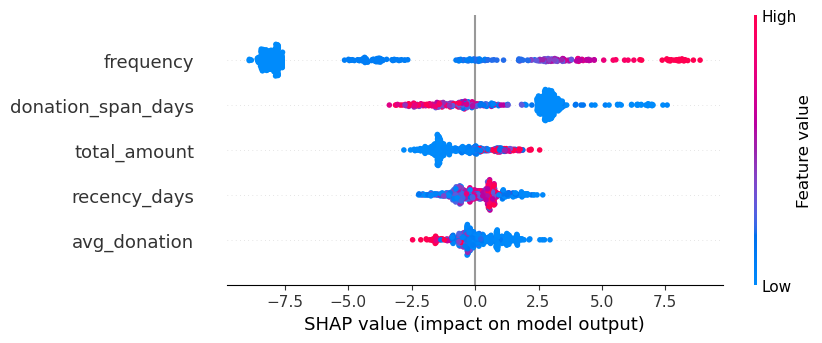

In [120]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

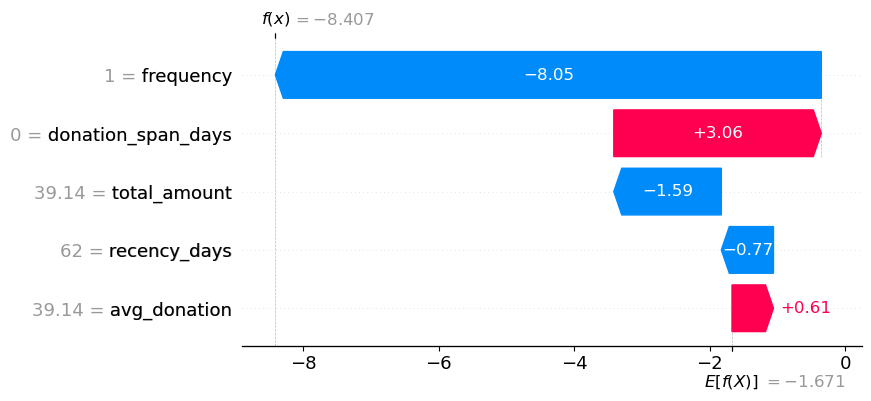

In [122]:
# Choose one row from your test set
i = 0  # Index of the donor you're analyzing
shap.plots.waterfall(shap_values[i])